<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
np.sum(data.isna())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Из информации data.info() видно, что TotalSpent имеет Dtype == object, в то время как по существу данные должны представлять собой вещественные числа. Так как поиск isna не дал результатов, то следует предположить, что там находятся какие-то символьные артефакты. Чтобы пронаблюдать их - сделаем сортировку

In [6]:
np.sort(data.TotalSpent)

array([' ', ' ', ' ', ..., '997.65', '998.1', '999.9'], dtype=object)

Видно, что присутствуют пробельные символы в значениях вместо вещественных чисел. Посмотрим, какое количество таких объектов.

In [7]:
np.unique(data.TotalSpent)

array([' ', '100.2', '100.25', ..., '997.65', '998.1', '999.9'],
      dtype=object)

In [8]:
np.count_nonzero(np.where(data.TotalSpent == ' ')[0])

9

Заполним пропущенные данные средними значениями по всей выборке. Для этого совершим два последовательных действия:
* Превратим все пробельные значения в np.nan, чтобы удобнее было работать в модуле np
* Скастим все значения в float

In [9]:
data['TotalSpent'] = data['TotalSpent'].replace(' ', np.nan)

In [10]:
print(np.sum(data.TotalSpent.isna()))

9


In [11]:
# Создадим временный объект pandas для хранения колонки TotalSpent без NA
data_tmp = data.TotalSpent.dropna()

In [12]:
# Преобразуем в float64 из строк
data_tmp = data_tmp.apply(pd.to_numeric)

In [13]:
# найдем индексы, где находятся пропуски в исходных данных
indexes_of_na = np.where(data.TotalSpent.isna())[0]

In [14]:
# Заполним пустые данные средними значениями и получим утечку данных, но таких объектов в тренировочном
# и тестовом датасете весьма мало, поэтому некритично
data.TotalSpent.iloc[indexes_of_na] = data_tmp.mean()

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


 Игнорируем этот ворнинг, потому что неважно копия или нет

In [15]:
# Преобразуем исходные объекты в числа
data.TotalSpent =  data.TotalSpent.apply(pd.to_numeric)

In [16]:
# Выведем среднее для проверки. Оно должно было остаться таким же
data.TotalSpent.mean() == data_tmp.mean()

True

In [17]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

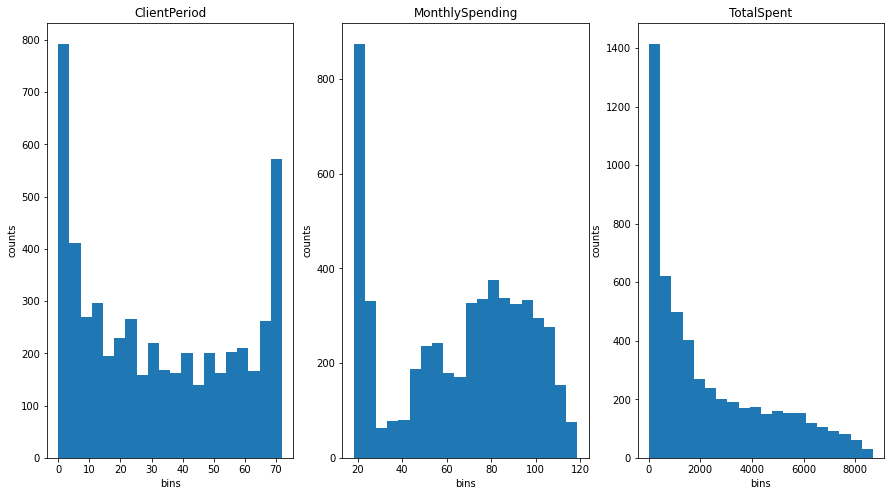

In [18]:
# Обработаем численные признаки

fig ,axs = plt.subplots(ncols = 3, figsize = (15,8))
for index, col in enumerate(num_cols):
    axs[index].hist(data[col], bins = 20)
    axs[index].title.set_text(col)
    axs[index].set_xlabel('bins')
    axs[index].set_ylabel('counts')

In [19]:
test = data.Sex.value_counts()

In [20]:
print(test.values)

[2655 2627]


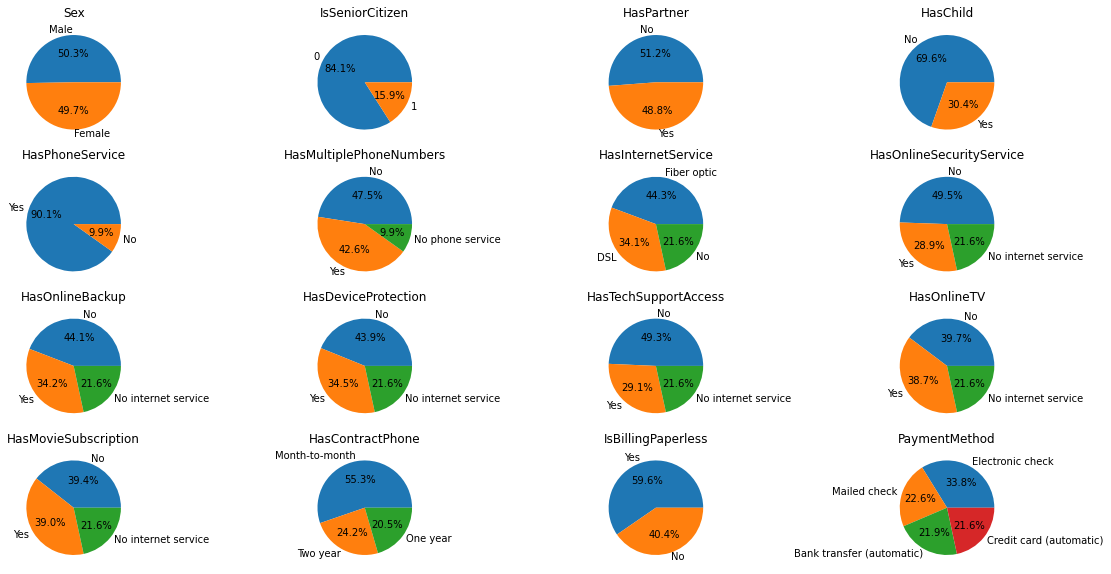

In [21]:
# Выпишим value_counts для каждой категориальной фичи
fig,axes = plt.subplots(4,4,figsize = (20,10))
axes = axes.flatten() # чтобы избежать указания двух индексов, то есть преобразуем в одномерный массив
for index, cat in enumerate(cat_cols):
    tmp_pandas_list_values_counts = data[cat].value_counts()
    #axes[index].bar(x= tmp_pandas_list_values.index, height = tmp_pandas_list_values.values)
    axes[index].pie(x = tmp_pandas_list_values_counts.values, labels = tmp_pandas_list_values_counts.index,
                   autopct = '%1.1f%%')
    axes[index].title.set_text(cat)

In [22]:
# Посмотрим на баланс классов в целевой переменной. Очевидно, что классы несбалансированы.
data.Churn.value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

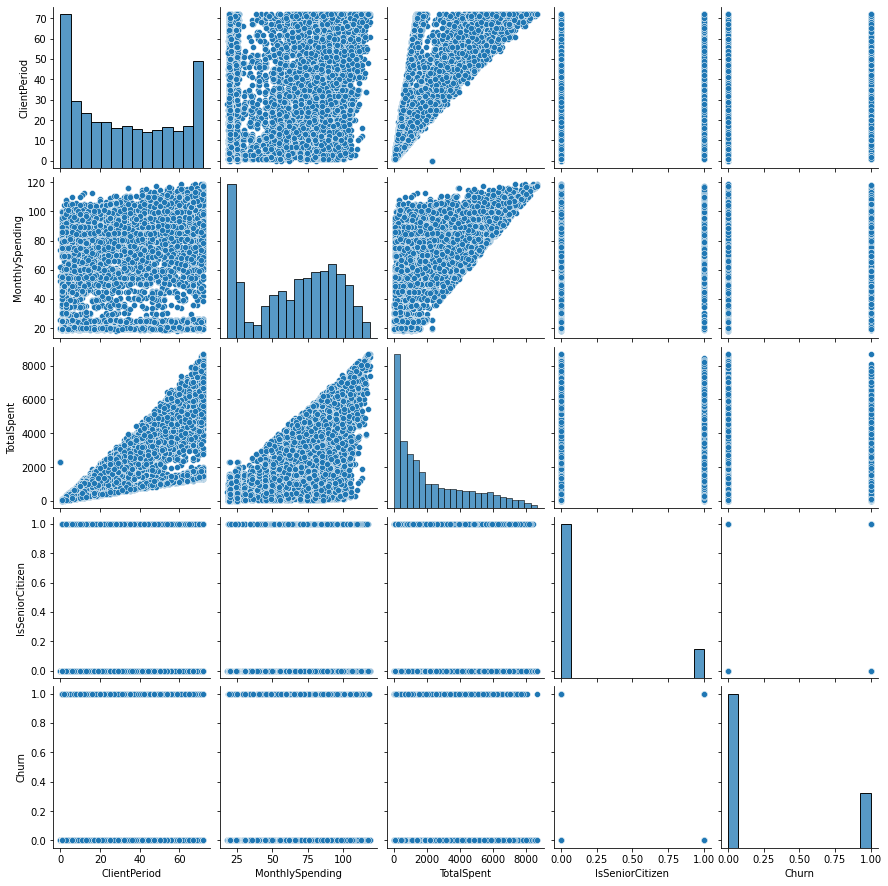

In [23]:
# Попробуем посмотреть pairplot, то есть завитсимость одного признака от другого
import seaborn
seaborn.pairplot(data)

In [24]:
# Поищем теперь корреляцию между вещественными признакми (+ бинарный) признаками. 
#Возьмем критерий Пирсона через встроенную функцию в pandas
data.corr()


,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
ClientPeriod,1.000000,0.249414,0.825103,0.011561,-0.350640
MonthlySpending,0.249414,1.000000,0.651510,0.215456,0.184769
TotalSpent,0.825103,0.651510,1.000000,0.093972,-0.201233
IsSeniorCitizen,0.011561,0.215456,0.093972,1.000000,0.156872
Churn,-0.350640,0.184769,-0.201233,0.156872,1.000000


Формально получается сильная корреляция между TotalSpent и двумя фичами ClientPeriod и MonthlySpending. Эта коррреляция объясняется чисто логически, исходя из определения признаков. В действительности, можно создать новую фичу, которая будет рассчитываться из двух скореллированных. 
Заметим, что целевая переменная churn имеет по модулю коэффициент корреляции с ClientPeriod, равный 0.35, что внушает оптимизм в то, что мы сможем обучиться на таком датасете

In [25]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [26]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Так как уже получили утечку данных, то сделаем более простой вариант, а именно разделение на train/valid выборки


In [28]:
# Преобразуем вещественные признаки с помощью StandardScaler
scaler = StandardScaler()
num_data_scaled = scaler.fit_transform(data[num_cols])

In [29]:
# Преобразуем категориальные признаки с помощью get_dummies
cat_data_encoded = pd.get_dummies(data[cat_cols], drop_first=True)

In [30]:
# Трансформируем num_data_scaled в pd.Series
num_data_scaled_pd = pd.DataFrame(num_data_scaled, columns=num_cols)

In [31]:
# Конкатенируем два массива, чтобы сделать X_train
X = np.hstack((num_data_scaled_pd, cat_data_encoded))

In [32]:
# разобьем на трейн и валид 
X_train,X_valid, y_train, y_valid = train_test_split(X,data[target_col], test_size = 0.1)

In [33]:
regressor = LogisticRegressionCV(scoring='roc_auc', refit=True)

In [34]:
regressor.fit(X_train, y_train)

LogisticRegressionCV(scoring='roc_auc')

In [35]:
res =  roc_auc_score(y_valid.values,regressor.predict_proba(X_valid)[:,1])

In [36]:
res

0.8567587892460988

Получилось относительно хорошее качество (недостаточно для 5 балла), вероятно, неправильные преобразования, поэтому для удобства реализуем пайплайн, в котором сделаем последовательно:
* Преобразование вещественных признаков через SimpleInputer со стратегиями замены на среднее, медиану и последующим нормированием через разные скейлеры
* Преобразование категориальных признаков через oneHotEncoder

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler

In [70]:
data_pipe = pd.read_csv('./train.csv')

In [71]:
data_pipe.TotalSpent = data_pipe.TotalSpent.replace(' ', np.nan)

In [72]:
data_pipe.TotalSpent = data_pipe.TotalSpent.apply(pd.to_numeric)

In [41]:
# Пройдем цикл заново, начиная с инпутеров
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                        ('scaler', 'passthrough')])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, num_cols),
                                    ('categorical', categorical_transformer, cat_cols)])
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(random_state=42, max_iter=10000))])

In [42]:
# Создадим сетку, чтобы обучаться 
param_grid = {
    'preprocessor__data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__data_transformer__categorical__imputer__strategy': ['constant','most_frequent'],
    'preprocessor__data_transformer__numerical__scaler': [StandardScaler(), RobustScaler(), 
                                                          MinMaxScaler()],
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'classifier__solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}

In [43]:
clf = GridSearchCV(classifier, param_grid, scoring='roc_auc')

In [44]:
clf.fit(data_pipe[feature_cols], data_pipe[target_col])

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           'passthrough')]),
                                                                                          ['ClientPeriod',
                                                                                           'MonthlySpending',
                                                              

In [45]:
clf.best_score_

0.8450555660632079

In [46]:
clf.best_params_

{'classifier__C': 100,
 'classifier__solver': 'liblinear',
 'preprocessor__data_transformer__categorical__imputer__strategy': 'constant',
 'preprocessor__data_transformer__numerical__imputer__strategy': 'median',
 'preprocessor__data_transformer__numerical__scaler': MinMaxScaler()}

Качество действительно получилось лучше: 0.845055, что уже неплохо

In [47]:
X_test = pd.read_csv('./test.csv')


In [48]:
# todo: Надо было добавить 2 шага в пайплайн, чтобы было удобнее
X_test.TotalSpent = X_test.TotalSpent.replace(' ', np.nan)
X_test.TotalSpent = X_test.TotalSpent.apply(pd.to_numeric)

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [49]:
# Используем catboost
import catboost

In [78]:
data_pipe['Custom'] = data_pipe.MonthlySpending / data_pipe.ClientPeriod

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(data_pipe[feature_cols], data_pipe.Churn,
                                                     test_size = 0.2)

In [65]:
model = catboost.CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',random_seed=42, verbose=200,
                                   cat_features=cat_cols)

In [52]:
param_grid = {'learning_rate':[0.1,0.05,0.03,0.15,0.2],
             'depth': [5,6,7,8,9,10],
             'iterations': [500,1000,1500]}

In [ ]:
model.grid_search(param_grid, X_train, y_train, partition_random_seed=42)

In [ ]:
model.get_all_params()

catboost : {'params': {'depth': 6, 'n_estimators': 800, 'learning_rate': 0.031}}



In [186]:
model_test = catboost.CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',
                                        random_state=42, verbose=300, 
                                        cat_features=cat_cols, depth = 6,
                                        learning_rate = 0.0312, use_best_model=True,
                                        n_estimators=700, l2_leaf_reg = 15.07)

In [185]:
model_test.fit(X_train, y_train, eval_set=(X_valid, y_valid),cat_features=cat_cols,use_best_model=True)

0:	learn: 0.8254470	test: 0.8354302	best: 0.8354302 (0)	total: 22.2ms	remaining: 15.5s
300:	learn: 0.8744203	test: 0.8547431	best: 0.8547431 (300)	total: 4.49s	remaining: 5.95s
600:	learn: 0.8916333	test: 0.8540495	best: 0.8554227 (348)	total: 9.52s	remaining: 1.57s
699:	learn: 0.8971892	test: 0.8536645	best: 0.8554227 (348)	total: 11.3s	remaining: 0us

bestTest = 0.8554227208
bestIteration = 348

Shrink model to first 349 iterations.


Выпишите какое лучшее качество и с какими параметрами вам удалось получить bestTest = 0.8564039043
depth = 6, learning_rate = 0.0312, n_estimators = 700 , l2_leaf_ret = 15.07

In [188]:
greedy_params_search = {'depth' : [6],
                       'learning_rate': np.linspace(0.031, 0.0320, num = 20),
                       'n_estimators' : [700],
                       'l2_leaf_reg': [15.07]}

In [189]:
model_greedy = catboost.CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',
                                          random_state=42, verbose=300,
                                          cat_features=cat_cols)

In [190]:
model_greedy.grid_search(greedy_params_search, X_train,y_train, cv = 5)


bestTest = 0.8507421309
bestIteration = 504

0:	loss: 0.8507421	best: 0.8507421 (0)	total: 14.5s	remaining: 4m 34s

bestTest = 0.8523628764
bestIteration = 459

1:	loss: 0.8523629	best: 0.8523629 (1)	total: 26s	remaining: 3m 54s

bestTest = 0.8524232989
bestIteration = 385

2:	loss: 0.8524233	best: 0.8524233 (2)	total: 38.3s	remaining: 3m 37s

bestTest = 0.8518226279
bestIteration = 422

3:	loss: 0.8518226	best: 0.8524233 (2)	total: 49.3s	remaining: 3m 17s

bestTest = 0.8519434729
bestIteration = 439

4:	loss: 0.8519435	best: 0.8524233 (2)	total: 1m 2s	remaining: 3m 6s

bestTest = 0.8509909295
bestIteration = 386

5:	loss: 0.8509909	best: 0.8524233 (2)	total: 1m 15s	remaining: 2m 55s

bestTest = 0.8517799767
bestIteration = 377

6:	loss: 0.8517800	best: 0.8524233 (2)	total: 1m 25s	remaining: 2m 39s

bestTest = 0.8511259916
bestIteration = 457

7:	loss: 0.8511260	best: 0.8524233 (2)	total: 1m 36s	remaining: 2m 24s

bestTest = 0.8502018823
bestIteration = 406

8:	loss: 0.8502019	best: 0

{'params': {'depth': 6,
  'iterations': 700,
  'learning_rate': 0.032,
  'l2_leaf_reg': 15.07},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
            

# Предсказания

In [193]:
best_model = model_test

In [192]:
#X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] =  best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index = False)

### Made by Zimin Vladimir
kaggle result = 0.85352


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.